In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_columns', 500)
label_encoder = LabelEncoder()

housing_factor_tuned = pd.read_pickle("housing_factor_tuned.pkl")
housing_numeric_scaled = pd.read_pickle("housing_numeric_scaled.pkl")
housing_factor_tuned = housing_factor_tuned.apply(label_encoder.fit_transform)
housing_combined = pd.concat([housing_numeric_scaled,housing_factor_tuned],axis=1)

In [19]:
housing_combined = housing_combined[['GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'Fireplaces', 'TotalBath', 'LotArea', 'MasVnrArea',
                                                             'OverallCond', 'GarageArea', 'YearRemodAdd', 'Foundation',
                                                             'TotRmsAbvGrd', 'GarageYrBlt', 'PoolArea', 'YrSold', 'MoSold', 'LotFrontage', 'OverallQual',
                                                             'BsmtQual', 'KitchenQual', "BsmtExposure", 'FireplaceQu', 'Neighborhood', 'HeatingQC', 'OpenPorchSF']].copy()

In [20]:
housing_numeric = pd.read_pickle("~/Documents/NYCDSA/Third Project/ML_Ames_Housing/Python/housing_numeric.pkl")
SalePrice = housing_numeric['SalePrice']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
gbm = GradientBoostingRegressor()

In [21]:
cross_val_score_gb = cross_val_score(gbm, housing_combined, SalePrice, scoring = 'r2', cv=kf, n_jobs = -1)
print(cross_val_score_gb)
print('Avg Score:',np.mean(cross_val_score_gb))
print('Variance:',np.var(cross_val_score_gb))

[0.90481894 0.85450023 0.90994725 0.92084458 0.908257  ]
Avg Score: 0.8996735989429689
Variance: 0.0005389082358381966


In [24]:
grid_para_gbm = { 
    'n_estimators': [50], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [None], 
    'max_leaf_nodes': [None] 
}
grid_search_gbm = GridSearchCV(gbm, grid_para_gbm, scoring = 'r2', cv= kf, n_jobs = -1)
%time grid_search_gbm.fit(housing_combined, SalePrice)

CPU times: total: 219 ms
Wall time: 2.79 s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [None], 'n_estimators': [50]},
             scoring='r2')

In [25]:
grid_search_gbm.best_score_

0.8884036168508

In [26]:
best_estimator = grid_search_gbm.best_estimator_
feature_importance = pd.Series(best_estimator.feature_importances_, index= housing_combined.columns).sort_values(ascending=False).head(28)
feature_importance

OverallQual     0.152376
GarageArea      0.110523
GrLivArea       0.106176
BsmtQual        0.100644
TotalBsmtSF     0.090973
YearBuilt       0.064594
TotRmsAbvGrd    0.053280
TotalBath       0.045211
MasVnrArea      0.029840
LotArea         0.029399
GarageYrBlt     0.028506
Fireplaces      0.027351
KitchenQual     0.026834
LotFrontage     0.025656
HeatingQC       0.023163
YearRemodAdd    0.018933
Neighborhood    0.014065
OpenPorchSF     0.012095
BsmtExposure    0.009933
FireplaceQu     0.008306
OverallCond     0.007561
MoSold          0.006201
Foundation      0.003992
YrSold          0.003980
PoolArea        0.000407
dtype: float64

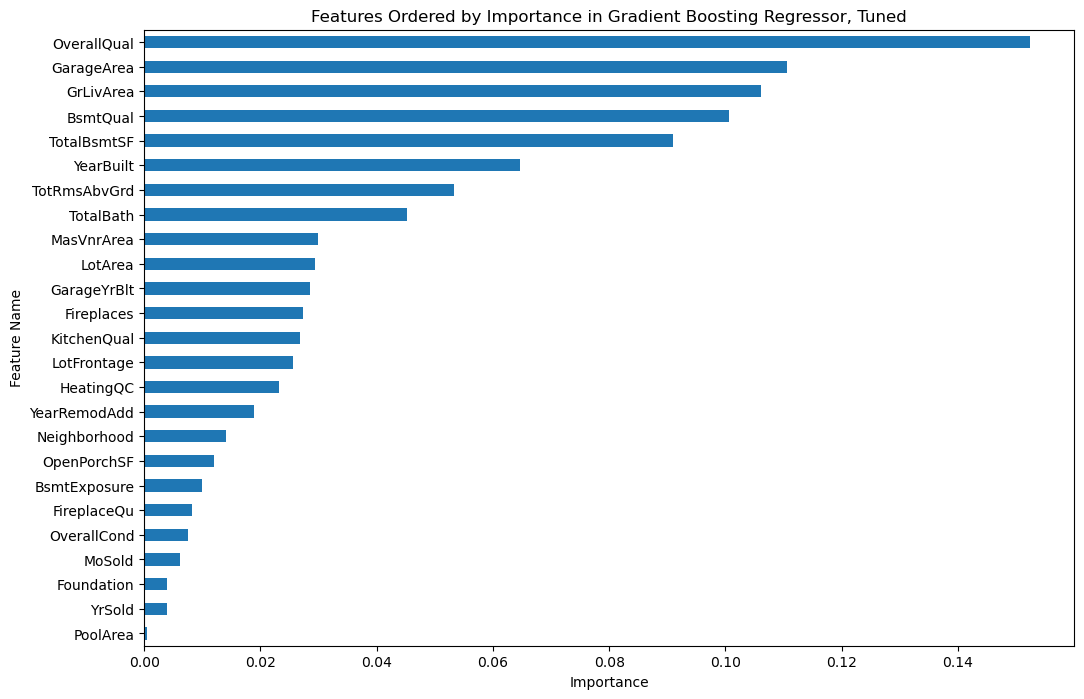

In [42]:
plt.figure(figsize=(12, 8))
feature_importance.plot(kind='barh')
plt.title(f'Features Ordered by Importance in Gradient Boosting Regressor, Tuned')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.gca().invert_yaxis() 

In [29]:
from sklearn.model_selection import KFold
fold_scores = []
fold_num = 1
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(housing_combined):
    
    X_train, X_test = housing_combined.iloc[train_index], housing_combined.iloc[test_index]
    y_train, y_test = SalePrice.iloc[train_index], SalePrice.iloc[test_index]
    
    grid_search = GridSearchCV(gbm, grid_para_gbm, cv=5, scoring='r2', n_jobs = -1, return_train_score=True)
    grid_search.fit(X_train, y_train)
    fold_score = grid_search.score(X_test, y_test)
    best_forest = grid_search.best_estimator_
    print(f'Score for Fold: {fold_num}', fold_score)
    print(f'Best Params for Fold {fold_num}', best_forest)

    # Store best parameters and score
    fold_scores.append({
        'score':fold_score,
        'fold':fold_num})
    fold_num += 1

Score for Fold: 1 0.8834314291715835
Best Params for Fold 1 GradientBoostingRegressor(max_depth=None, max_features='log2', n_estimators=50)
Score for Fold: 2 0.8738109563352247
Best Params for Fold 2 GradientBoostingRegressor(max_depth=None, max_features='sqrt', n_estimators=50)
Score for Fold: 3 0.899869195254083
Best Params for Fold 3 GradientBoostingRegressor(max_depth=None, max_features='log2', n_estimators=50)
Score for Fold: 4 0.9026351576695697
Best Params for Fold 4 GradientBoostingRegressor(max_depth=None, max_features='sqrt', n_estimators=50)
Score for Fold: 5 0.8921665506201552
Best Params for Fold 5 GradientBoostingRegressor(max_depth=None, max_features='sqrt', n_estimators=50)


In [30]:
total_score = 0
for i, el in enumerate(fold_scores):
    total_score += el['score']
    avg_score = total_score / (i+1)
print(avg_score)

0.8903826578101232


In [32]:
gbm.fit(X_train,y_train)

GradientBoostingRegressor()

In [39]:
important_features2 = gbm.feature_importances_
feature_importances2 = pd.Series(important_features2, index=X_train.columns).head(25)
feature_importances2 = feature_importances2.sort_values(ascending=False)

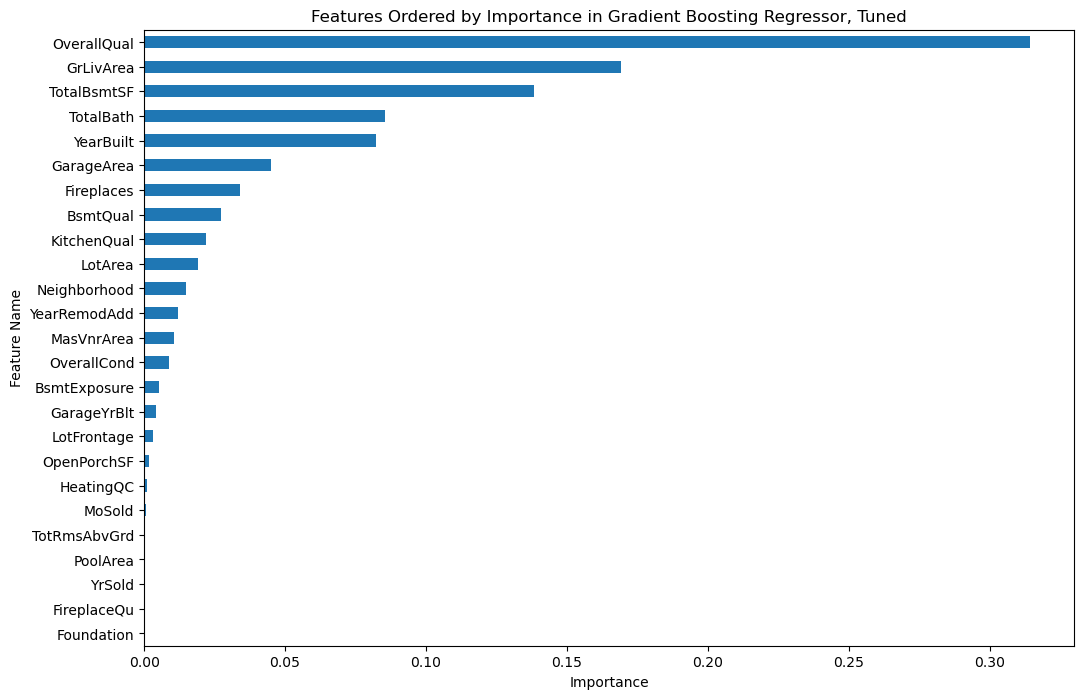

In [41]:
plt.figure(figsize=(12, 8))
feature_importances2.plot(kind='barh')
plt.title(f'Features Ordered by Importance in Gradient Boosting Regressor, Tuned')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.gca().invert_yaxis() 